# **EE5178: Panoramic Stitching**
## -B Aditi
##  MM19B022



# Brief Overview

In this problem set, you will implement panoramic stitching. Given two input images, we will "stitch" them together to create a simple panorama. To construct the image panorama, we will use concepts learned in class such as keypoint detection, local invariant descriptors, RANSAC, and perspective warping. 

The panoramic stitching algorithm consists of four main steps which we ask you to implement in individual functions:

1. Detect keypoints and extract local invariant descriptors from two input images. 

2. Match the descriptors between the two images.

3. Apply RANSAC to estimate a homography matrix between the extracted features.

4. Apply a perspective transformation using the homography matrix to merge image into a panorama.

Functions to implement (refer to function comments for more detail):

1. get_features

2. match_keypoints

3. find_homography and transform_ransac 

4. panoramic_stitching

# Starting

Run the following code to import the modules you'll need. After your finish the assignment, remember to run all cells and save the note book to your local machine as a .ipynb file for Canvas submission.

In [162]:
%matplotlib inline
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import numpy.ma as ma

In [2]:
%%capture
! wget -O img1.jpg "https://drive.google.com/uc?export=download&id=1omMydL6ADxq_vW5gl_1EFhdzT9kaMhUt"
! wget -O img2.jpg "https://drive.google.com/uc?export=download&id=12lxB1ArAlwGn97XgBgt-SFyjE7udMGvf"

# Visualize Input Images

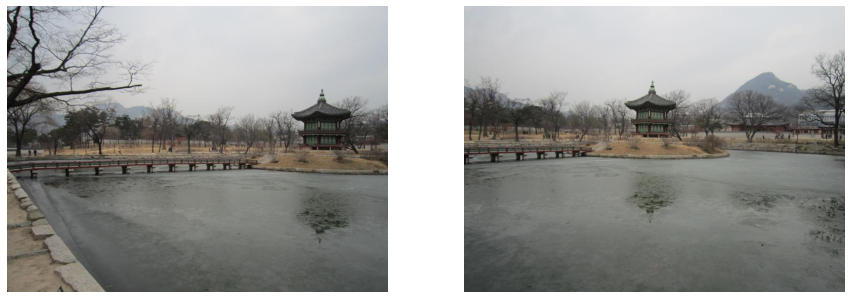

In [3]:
img1 = plt.imread('img1.jpg')
img2 = plt.imread('img2.jpg')

def plot_imgs(img1, img2):
  fig, ax = plt.subplots(1, 2, figsize=(15, 20))
  for a in ax:
    a.set_axis_off()
  ax[0].imshow(img1)
  ax[1].imshow(img2)

plot_imgs(img1, img2)

# Compute SURF/ SIFT/ ORB Features and Match Keypoints

In [4]:
def get_features(img):
  '''
    Compute SURF/SIFT/ORB features using cv2 library functions. Use default parameters when computing the keypoints.
    Input: 
      img: cv2 image
    Returns:
      keypoints: a list of cv2 keypoints
      descriptors: a list of feature descriptors
  '''
  # ===============================================
  # TODO
  # ===============================================
  orb = cv2.ORB_create()
  keypoints, descriptors = orb.detectAndCompute(img,None)
  return keypoints, descriptors

def match_keypoints(desc_1, desc_2, ratio=0.75):
  '''
    You may use cv2 library functions.
    Input:
      desc_1, desc_2: list of feature descriptors
    Return:
      matches: list of feature matches
  '''
  # ===============================================
  # TODO
  # ===============================================
  bf = cv2.BFMatcher()
  matches = bf.knnMatch(desc_1, desc_2, k=2)

  good = []
  for m,n in matches:
    if m.distance < 0.75*n.distance:
      good.append([m])

  good = sorted(good, key = lambda x : x[0].distance)
    
  

  return good

keypoints for img1 and img2


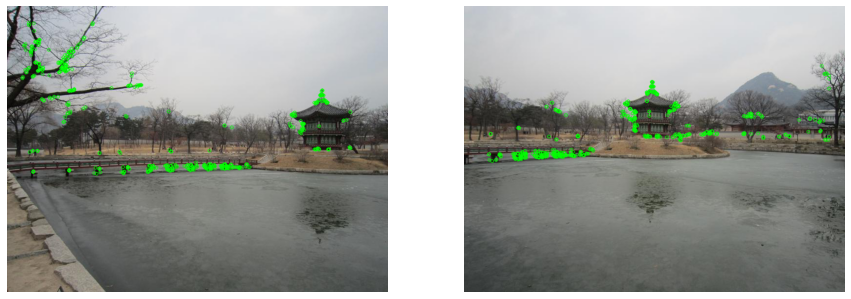

In [5]:
kp_1, desc_1 = get_features(img1)
kp_2, desc_2 = get_features(img2)

kp_img1 = cv2.drawKeypoints(img1, kp_1, None, color=(0,255,0), flags=0)
kp_img2 = cv2.drawKeypoints(img2, kp_2, None, color=(0,255,0), flags=0)

print('keypoints for img1 and img2')
plot_imgs(kp_img1, kp_img2)

feature matches


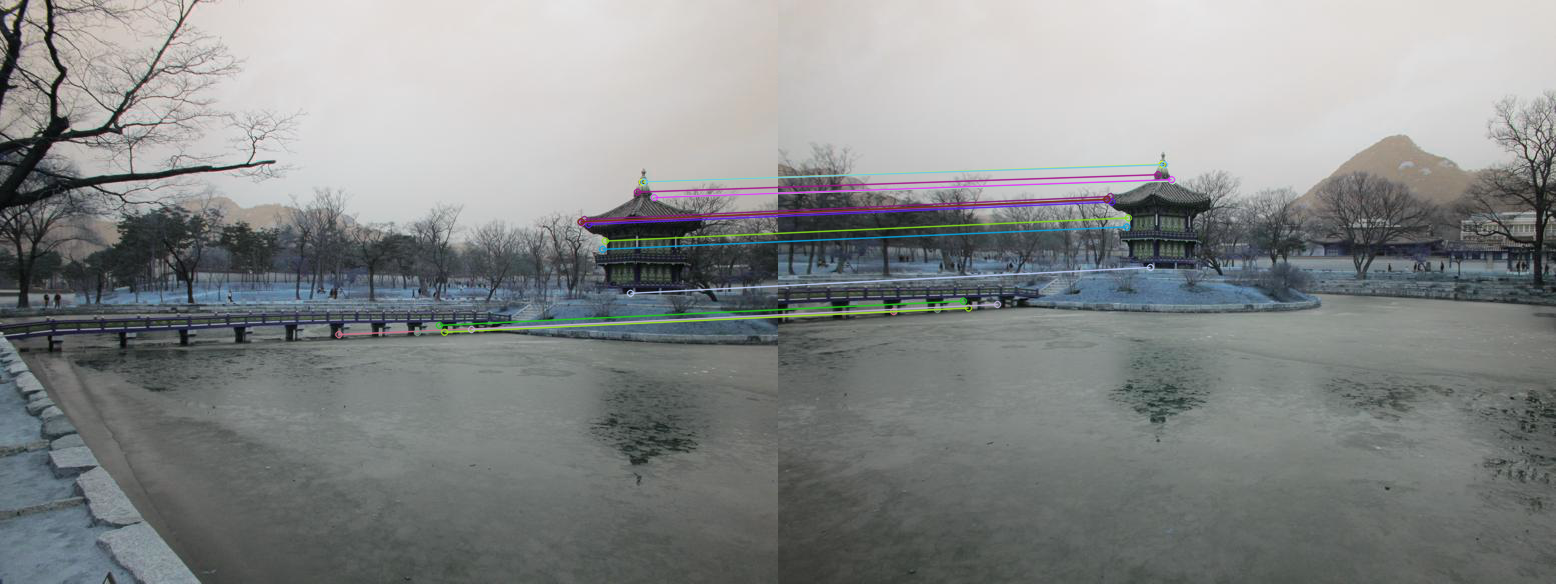

In [6]:
matches = match_keypoints(desc_1, desc_2)[:20]

match_plot = cv2.drawMatchesKnn(img1, kp_1, img2, kp_2, matches, None, flags=2)
print("feature matches")
cv2_imshow(match_plot)

# Compute Homography Matrix using RANSAC

In [227]:
def find_homography(pts_1, pts_2):
  '''
    Implement Direct Linear Transform to find a homography that estimates the transformation mapping from pts_1 to pts_2.
    e.g. If x is in pts_1 and y is in pts_2, then y = H * x
    Input:
      pts_1, pts_1: (N, 2) matrix 
    Return:
      H: the resultant homography matrix (3 x 3)
  '''
  # ===============================================
  # TODO
  # ===============================================
  n = np.shape(pts_1)[0]
  #print(pts_1)
  pts_1 = np.array(pts_1)
  pts_2 = np.array(pts_2)
  pts_1t = np.transpose(pts_1)
  pts_2t = np.transpose(pts_2)
  
  x_s, y_s = np.transpose(pts_1t[0][:]), np.transpose(pts_1t[1][:])
  x_t, y_t = np.transpose(pts_2t[0][:]), np.transpose(pts_2t[1][:])
  
  z_s = z_t = np.ones((n,1))
  #m = np.shape(x_s)[0]
  #print(x_t)

  A = []

  for i in range(n):
    temp = np.array([[0, 0, 0, -z_t[i]*x_s[i], -z_t[i]*y_s[i], -z_t[i]*z_s[i], y_t[i]*x_s[i], y_t[i]*y_s[i], y_t[i]*z_s[i]],
                     [z_t[i]*x_s[i], z_t[i]*y_s[i], z_t[i]*z_s[i], 0, 0, 0, -x_t[i]*x_s[i], -x_t[i]*y_s[i], -x_t[i]*z_s[i]]])
    A.append(temp)

  A = np.concatenate(A, axis = 0)
  #print(A)
  A = np.array(A, dtype = 'float64')
  #print(A.shape)
  u, s, v = np.linalg.svd(A, full_matrices = True)
  #print((v[-1]).shape)
  H = v[-1].reshape((3,3))
  H = H/H[2,2]

  return H

In [228]:
from numpy.linalg.linalg import zeros

def transform_ransac(pts_1, pts_2):
  '''
    Implement RANSAC to estimate homography matrix.
    Input:
      pts_1, pts_1: (N, 2) matrices
    Return:
      best_model: homography matrix with most inliers
  '''
  # ===============================================
  # TODO
  # ===============================================
  N = len(pts_1)
  iter = 2999
  z = [1 for i in range(N)]
  e = 10
  best_in = 0

  pts_in = []
  x_sub = []
  y_sub = []

  pts1n=[]
  pts2n=[]
  for i in pts_1:
    pts1n.append(list(i)+[1])
  for i in pts_2:
    pts2n.append(list(i)+[1])
  pts_1=np.array(pts1n)
  pts_2=np.array(pts2n)
  print(pts_1.shape)
 
  for i in range(iter):
    indices = random.sample(range(0, N-1), 4)
    sub_1 = []
    sub_2 = []
    for j in range(0, 4):
      sub_1.append(pts_1[indices[j]])
      sub_2.append(pts_2[indices[j]])

    H = find_homography(sub_1, sub_2)
    '''
    pts_1t=np.transpose(np.array(pts_1))
    pts_2t=np.transpose(np.array(pts_2))
    zt=np.transpose(z)
    pts_1t=np.concatenate(pts_1t,zt)
    pts_2t=np.concatenate(pts_2t,zt)
    '''
    
    pts_2_pred = np.matmul(pts_1, H)
    diff = pts_2 - pts_2_pred 

    mask = diff < e
    diff_in = ma.masked_array(diff, mask)
    pt1 = ma.masked_array(pts_1, mask)
    pt2 = ma.masked_array(pts_2, mask)

    n_in = len(diff_in)

    if n_in>best_in:
      best_in = n_in
      best_subset_x = pt1
      best_subset_y = pt2

  best_model = find_homography(best_subset_x, best_subset_y)

  return best_model

# Panoramic Stitching

In [229]:
def panoramic_stitching(img1, img2):
  '''
    Generate a panoramic image using the obtained homography matrix.
    Input: 
      img1, img2: cv2 images
    Return:
      final_img: cv2 image of panorama
  '''
  # ===============================================
  # TODO
  # ===============================================
  kp_1, desc_1 = get_features(img1)
  kp_2, desc_2 = get_features(img2)

  kp_img1 = cv2.drawKeypoints(img1, kp_1, None, color=(0,255,0), flags=0)
  kp_img2 = cv2.drawKeypoints(img2, kp_2, None, color=(0,255,0), flags=0)
  matches = match_keypoints(desc_1, desc_2)

  pts_1 = []
  pts_2 = []
  for m in matches:
    m = m[0]
    p1 = kp_1[m.queryIdx].pt
    p2 = kp_2[m.trainIdx].pt
    pts_1.append(p1)
    pts_2.append(p2)

  H = transform_ransac(pts_2, pts_1)
  H_inv = np.linalg.inv(H)

  xmax = 0
  ymax = 0

  for x in [0, img2.shape[1]-1]:
    for y in [0, img2.shape[0]-1]:
      point = np.array([x, y, 1])
      t_point = np.matmul(H, point)
      t_point = t_point/t_point[2]
      tx, ty = t_point[0], t_point[1]

      if tx>xmax:
        txmax = tx
      if ty>ymax:
        tymax = ty

  tymax = int(tymax)
  txmax = int(txmax)
  final_img = np.zeros([max(tymax, img1.shape[0]), max(txmax, img1.shape[1]), img2.shape[2]])

  for i in range(max(tymax, img1.shape[0])):
    for j in range(max(txmax, img1.shape[1])):
      point = np.array([j, i, 1])
      og_point = np.matmul(H_inv, point)
      og_point = og_point/og_point[2]
      x, y = og_point[0], og_point[1]
      x = int(x)
      y = int(y)
      if x>=0 and x<np.shape(img2)[1] and y>=0 and y<np.shape(img2)[0]:
        final_img[i, j, :] = img2[y, x, :]

  final_img[0:img1.shape[0], 0:img1.shape[1]] = img1


  return final_img

(53, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


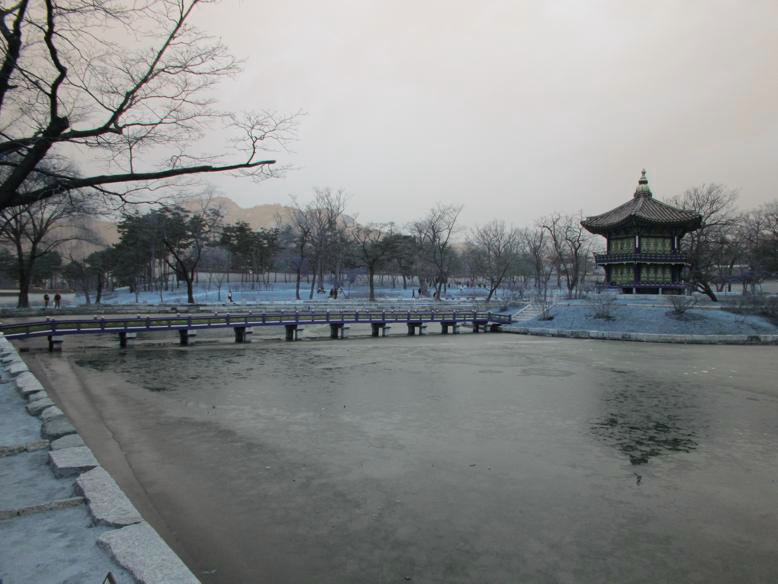

In [230]:
result = panoramic_stitching(img1, img2)
cv2_imshow(result)

# The 3 image problem

In [232]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [240]:
%%capture
! wget -O img_1.jpg "https://drive.google.com/file/d/1Iw-KBQyujaNesg4aebrxwsSIef-cHPhr/view?usp=sharing"
! wget -O img_2.jpg "https://drive.google.com/file/d/1d0ZUAqljLMPrd8RjrEAgbJ4tA-2bYyvP/view?usp=sharing"
! wget -O img_3.jpg "https://drive.google.com/file/d/1TN248Jus2K8h8Alcaz2ez7YUrJJTX9IM/view?usp=sharing"

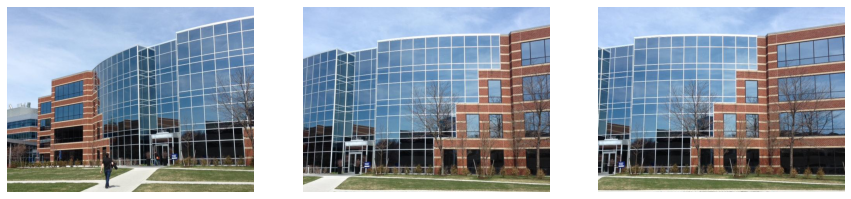

In [245]:
img_1 = plt.imread('image1.jpg')
img_2 = plt.imread('image2.jpg')
img_3 = plt.imread('image3.jpg')

fig, ax = plt.subplots(1, 3, figsize=(15, 30))
for a in ax:

  a.set_axis_off()
ax[0].imshow(img_1)
ax[1].imshow(img_2)
ax[2].imshow(img_3)

(70, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


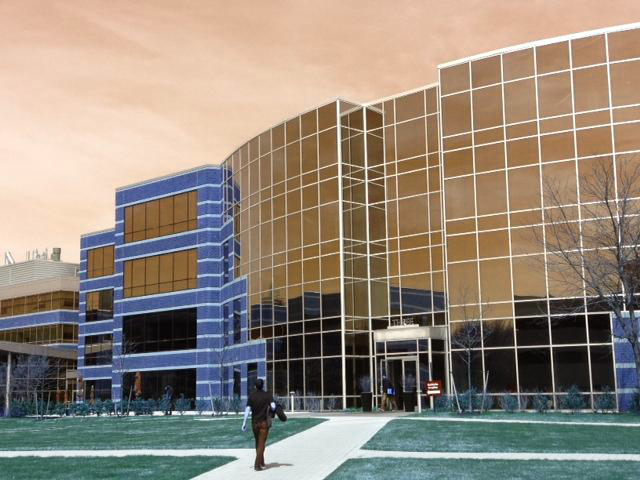

In [247]:
res1 = panoramic_stitching(img_1, img_2)
cv2_imshow(res1)

(103, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


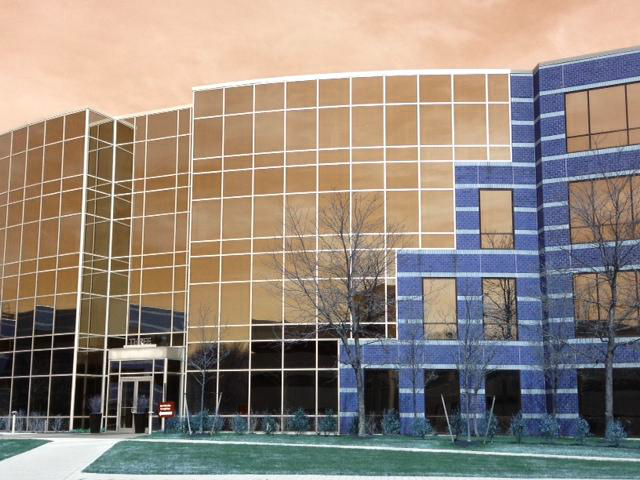

In [248]:
res2 = panoramic_stitching(img_2, img_3)
cv2_imshow(res2)

In [250]:
cv2.imwrite('res1.jpg', res1)
cv2.imwrite('res2.jpg', res2)

True

In [251]:
res1 = cv2.imread('res1.jpg')
res2 = cv2.imread('res2.jpg')

(68, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


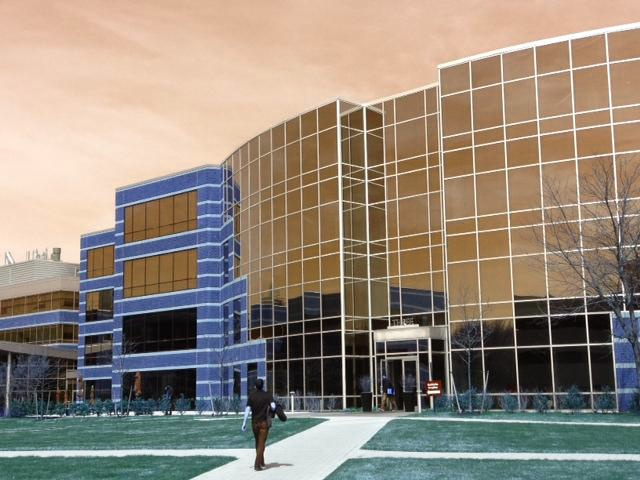

In [252]:
res_final = panoramic_stitching(res1, res2)
cv2_imshow(res_final)